In [0]:
!pip install rake-nltk
!pip install fuzzywuzzy
!pip install PanelGroupBy
!pip install wget

ERROR: Could not find a version that satisfies the requirement PanelGroupBy (from versions: none)
ERROR: No matching distribution found for PanelGroupBy


In [0]:
import pandas as pd
from google.colab import files
import json
import sqlite3

import urllib
import zipfile

import time

from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure


import csv   
import nltk
import numpy as np
import os
from gensim.models import word2vec
import gensim

import string
from nltk.corpus import stopwords
from rake_nltk import Rake
from tqdm import tqdm
from nltk.metrics import edit_distance
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import utils
import csv
from tqdm import tqdm
import multiprocessing
import nltk
from nltk.corpus import stopwords

#1. Generating Dataset
In this step, we download all the files for our dataset and process it into a raw text feature dataframe and raw text label dataframe


In [0]:
url = 'https://upenn-bigdataanalytics.s3.amazonaws.com/linkedin.zip'
filehandle, _ = urllib.request.urlretrieve(url,filename='local.zip')
filehandle = 'local.zip'

In [0]:
url = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
fh, _ = urllib.request.urlretrieve(url,'GoogleNews-vectors-negative300.bin.gz')
fh = 'GoogleNews-vectors-negative300.bin.gz'

In [0]:
google_model = gensim.models.KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def fetch_file(fname):
    zip_file_object = zipfile.ZipFile(filehandle, 'r')
    for file in zip_file_object.namelist():
        file = zip_file_object.open(file)
        if file.name == fname: return file
    return None
    
linkedin_tiny = fetch_file('linkedin_tiny.json')
linkedin_small = fetch_file('linkedin_small.json')
linkedin_huge = fetch_file('linkedin.json')

In [0]:
#choose the file to process
file = linkedin_small

START = 0
LIMIT = 50000

def get_df(rel):
    ret = pd.DataFrame(rel).fillna('')
    for k in ret.keys():
        ret[k] = ret[k].astype(str)
    return ret

def extract_relation(rel, name):
    '''
    Pull out a nested list that has a key, and return it as a list
    of dictionaries suitable for treating as a relation / dataframe
    '''
    # We'll return a list
    ret  = []
    if name in rel:
        ret2 = rel.pop(name)
        try:
            # Try to parse the string as a dictionary
            ret2 = json.loads(ret2.replace('\'','\"'))
        except:
            # If we get an error in parsing, we'll leave as a string
            pass
        
        # If it's a dictionary, add it to our return results after
        # adding a key to the parent
        if isinstance(ret2, dict):
            item = ret2
            item['person'] = rel['_id']
            ret.append(item)
        else:
            # If it's a list, iterate over each item
            index = 0
            for r in ret2:
                item = r
                if not isinstance(item, dict):
                    item = {'person': rel['_id'], 'value': item}
                else:
                    item['person'] = rel['_id']
                    
                # A fix to a typo in the data
                if 'affilition' in item:
                    item['affiliation'] = item.pop('affilition')
                    
                item['pos'] = index
                index = index + 1
                ret.append(item)
    return ret
    

names = []
people = []
groups = []
education = []
skills = []
experience = []
honors = []
also_view = []
events = []


conn = sqlite3.connect('linkedin.db')

lines = []
i = 1
for line in file:
    if i > START + LIMIT:
        break
    elif i >= START:
        try: 
          person = json.loads(line)

          # By inspection, all of these are nested dictionary or list content
          nam = extract_relation(person, 'name')
          edu = extract_relation(person, 'education')
          grp = extract_relation(person, 'group')
          skl = extract_relation(person, 'skills')
          exp  = extract_relation(person, 'experience')
          hon = extract_relation(person, 'honors')
          als = extract_relation(person, 'also_view')
          eve = extract_relation(person, 'events')

          # This doesn't seem relevant and it's the only
          # non-string field that's sometimes null
          if 'interval' in person:
              person.pop('interval')

          lines.append(person)
          names = names + nam
          education = education + edu
          groups  = groups + grp
          skills = skills + skl
          experience = experience + exp
          honors = honors + hon
          also_view = also_view + als
          events = events + eve
        except:
          display("error, pass on", i)
          pass
        
    i = i + 1

people_df = get_df(pd.DataFrame(lines))
names_df = get_df(pd.DataFrame(names))
education_df = get_df(pd.DataFrame(education))
groups_df = get_df(pd.DataFrame(groups))
skills_df = get_df(pd.DataFrame(skills))
experience_df = get_df(pd.DataFrame(experience))
honors_df = get_df(pd.DataFrame(honors))
also_view_df = get_df(pd.DataFrame(also_view))
events_df = get_df(pd.DataFrame(events))


In [0]:
conn = sqlite3.connect('linkedin.db')

# YOUR CODE HERE

# Save these to the SQLite database

people_df.to_sql('people', conn, if_exists='replace', index=False)
names_df.to_sql('names', conn, if_exists='replace', index=False)
education_df.to_sql('education', conn, if_exists='replace', index=False)
groups_df.to_sql('groups', conn, if_exists='replace', index=False)
skills_df.to_sql('skills', conn, if_exists='replace', index=False)
experience_df.to_sql('experience', conn, if_exists='replace', index=False)
honors_df.to_sql('honors', conn, if_exists='replace', index=False)
also_view_df.to_sql('also_view', conn, if_exists='replace', index=False)
events_df.to_sql('events', conn, if_exists='replace', index=False)



In [0]:
conn.execute('DROP TABLE  IF EXISTS people_complete')
conn.execute('''CREATE TABLE people_complete AS 
SELECT *
FROM people P
INNER JOIN names N ON N.person = P._id
INNER JOIN education E on E.person = P._id
INNER JOIN skills S on S.person = P._id
INNER JOIN honors H on H.person = P._id
INNER JOIN groups G on G.person = P._id
INNER JOIN experience EXP on EXP.person = P._id AND EXP.end = 'Present'
GROUP BY P._id
''')

get_people = '''SELECT _id, locality, industry, summary, specilities,interests,family_name, 	given_name, person, start	, major	, end	, name, 	desc, 	person, 	pos, 	degree,member, affilition
FROM people_complete
'''
get_people_label = '''SELECT _id, title, org FROM people_complete'''

people_feature_df = pd.read_sql_query(get_people, conn)
people_label_df = pd.read_sql_query(get_people_label, conn)


In [0]:
#Generating raw text dataset for pre-processing

people_feature_df.describe()
# people_feature_df.to_csv('feature.csv')
# people_label_df.to_csv('label.csv')
# files.download('label.csv')
# files.download('feature.csv')


#2. Processing dataset
With the raw text feature dataframe and raw label space, we process it into the feature space and label we needed for training. 


In [0]:

def load_feature_data():
    '''
    load raw data linkedin.zip, convert to list
    '''
    #load data
    with open('feature.csv','rt') as features:
        reader = csv.reader(features)
        frow = [row for row in reader]

    resume=[]
    r = Rake()
    for i in range(1,len(frow)):
        v=[]
        #print(resume)
        #os.system("Pause")
        for j in range(2,len(frow[i])):
            if j==7 or j==8 or j==9 or j==10 or j==12 or j==15 or j==16:
                continue
            ff=frow[i][j].lower()
            remove = str.maketrans('','',string.punctuation) 
            ff = ff.translate(remove)
            
            r.extract_keywords_from_text(ff)
            
            k=r.get_ranked_phrases()
            
            tok=[]
            for ii in range(len(k)):
                if ii>2:
                    break
                tokens=nltk.word_tokenize(k[ii])
                if len(tokens)<=3:
                    tok.extend(tokens)
                else:
                    tok.extend(tokens[:3])
            
            
            v.append(tok)
            
        resume.append(v)
    return resume

def load_label_data():
    '''
    load raw data linkedin.zip, convert the job titles to list
    '''
    with open('label.csv','rt') as features:
        reader = csv.reader(features)
        frow = [row for row in reader]
    
    job=[]
    for i in range(1,len(frow)):
        tokens=frow[i][2].lower()
        remove = str.maketrans('','',string.punctuation) 
        tokens=tokens.translate(remove)
        tokens=nltk.word_tokenize(tokens)
        tokens=" ".join(tokens)
        job.append(tokens)
    return job

def load_model():
    '''
    load gensim models
    '''
    model1 = gensim.models.KeyedVectors.load_word2vec_format("model/Model.bin", binary=True)
    model2 = gensim.models.KeyedVectors.load_word2vec_format("model/GoogleNews-vectors-negative300.bin", binary=True)
    return model1,model2

def write_csv(res):
    '''
    write the fuzzy labels to csv
    '''
    with open("result.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        for row in res:
            writer.writerow(row)

def load_result():
    '''
    load fuzzy labels
    '''
    with open('result.csv','rt') as features:
        reader = csv.reader(features)
        frow = [row for row in reader]
    return frow

def base_line(x_test,x_train,model1,model2):
    '''
    base line experiment
    input:
        x_test: test data features
        x_train: train data features
        model1:gensim model 1, include daily words models
        model2:gensim model 2, include job title models
    output:
        write the job title to csv file
    '''
    res=[]
    pre=-1.0
    weight=[0.045,0.27,0.09,0.154,0.009,0.136,0.045,0.09,0.054,0.009,0.09]
    for i in tqdm(range(len(x_test))):
        for j in range(len(x_train)):
            score=0.0
            for k in range(len(x_train[0])):
                if x_train[j][k]=="" or x_test[i][k]=="":
                    continue

                s=0.0
                c=0.0
                for ii in x_train[j][k]:
                    for jj in x_test[i][k]:
                        flag1=False
                        flag2=False
                        c+=1
                        try:
                            s+=model1.similarity(ii,jj)
                        except:
                            flag1=True

                        try:
                            s+=model2.similarity(ii,jj)
                        except:
                            flag2=True
                        if (not flag1) and (not flag2):
                            s/=2
                        if flag1 and flag2:
                            c-=1

                if c==0:
                    score+=fuzz.token_sort_ratio(x_train[j][k],x_test[i][k])/100
                    score*=weight[k]
                else:
                    score+=s/c
            
            if (score)>pre:
                pre=score
                result=y_train[j]
        res.append([result])
    write_csv(res)

def base_acc(y_te,r):
    '''
    compute accuracy of base line method
    '''
    count=0
    for i in range(len(y_te)):
        if y_te[i]==r[i]:
            count+=1
    print(count/len(y_te))

def convert_class(y,result,model1,model2,job):
    '''
    fuzzy labels
    input:
        y: job titles in raw data
        result: predicted job titles in unsupervised data(base line)
        model1: gensim model 1, include daily words models
        model2: gensim model 2, include job title models
        job: given job title
    output:
        flabel: fuzzy labels in raw data
        rlabel: labels in baseline prediction
        clabel: labels in baseline raw data
    '''
    clabel=[]
    rlabel=[]
    flabel=[]

    jt=nltk.word_tokenize(job)
    for t in tqdm(y):
        tw=nltk.word_tokenize(t)
        s=0
        count=0
        for i in tw:
            for j in jt:
                s1=0
                s2=0
                count+=1
                try:
                    s1=model1.similarity(i,j)
                except:
                    pass
                try:
                    s2=model2.similarity(i,j)
                except:
                    pass
                if s1==0 and s2==0:
                    s+=0
                elif s1==0 and s2!=0:
                    s+=s2
                elif s1!=0 and s2==0:
                    s+=s1
                else:
                    s+=0.2*s1+0.8*s2
            s/=count/2
        if s>=0.5:
            flabel.append([1,s])
            clabel.append(1)
        else:
            flabel.append([0,1-s])
            clabel.append(0)

    for t in tqdm(result):
        tw=nltk.word_tokenize(t[0])
        s=0
        count=0
        for i in tw:
            for j in jt:
                s1=0
                s2=0
                count+=1
                try:
                    s1=model1.similarity(i,j)
                except:
                    pass
                try:
                    s2=model2.similarity(i,j)
                except:
                    pass
                if s1==0 and s2==0:
                    s+=0
                elif s1==0 and s2!=0:
                    s+=s2
                elif s1!=0 and s2==0:
                    s+=s1
                else:
                    s+=0.2*s1+0.8*s2
            s/=count/2
        if s>=0.5:
            rlabel.append(1)
        else:
            rlabel.append(0)
    return clabel,rlabel,flabel
    


#3. Baseline Model

In [0]:
model1,model2=load_model()
x_train,y_train,x_test,y_test=load_feature_data()[:1925],load_label_data()[:1925],load_feature_data()[1925:],load_label_data()[1925:]

#base_line(x_test,x_train,model1,model2)

result=load_result()
job="product manager"
y,r,fy=convert_class(y_train+y_test,result,model1,model2,job)

print(fy)# fy is the fuzzy labels

base_acc(y[1925:],r)

#4. Machine Learning Model Training

In [0]:
def load_fuzzy_labels(path):
    '''
    load raw data linkedin.zip, convert the job titles to list
    '''
    label = []
    with open(path,'rt') as labels:
      reader = csv.reader(labels)
      for line in reader:
        label.append(int(line[0]))
    return label

labels = load_fuzzy_labels('/content/fuzzy label.csv')
#print(labels)

In [0]:

#tqdm.pandas(desc="progress-bar")
# Function for tokenizing
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

def concat_features(keys, row):
  output = ""
  for key in keys:
    output += row[key] + ' '

  return output


def translate_to_feature_space(raw, keys, split_cut, labels):
  # Initializing the variables
  train_documents = []
  test_documents = []
  for index, row in people_feature_df.iterrows():
      raw_feature = concat_features(keys, row)
      if index <= split_cut:
        train_documents.append(TaggedDocument(words=tokenize_text(raw_feature), tags=[labels[index]] ))
      else:
        test_documents.append( TaggedDocument(words=tokenize_text(raw_feature), tags=[labels[index]]))
                                              
  return (train_documents,test_documents)




In [0]:

def generate_training_data_set(split, keys):
  
  train_documents, test_documents = translate_to_feature_space(people_feature_df, keys, split, labels)
  
  cores = 2
  model_dbow = Doc2Vec(dm=1, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores, alpha=0.025, min_alpha=0.001)
  model_dbow.build_vocab([x for x in train_documents])
  train_documents  = utils.shuffle(train_documents)
  model_dbow.train(train_documents,total_examples=len(train_documents), epochs=30)
  def vector_for_learning(model, input_docs):
      sents = input_docs
      targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
      return targets, feature_vectors

  y_train, X_train = vector_for_learning(model_dbow, train_documents)
  return y_train, X_train

In [0]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes",'Logistic' ]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression(n_jobs=1, C=1e5)]

In [0]:
from sklearn.model_selection import KFold
def get_cross_validation_accuracy(X, y, classifier):
  
  kf = KFold(n_splits=2)
  KFold(n_splits=2, random_state=None, shuffle=False)
  accuracy = []
  for train_index, test_index in kf.split(X):

      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      classifier.fit(X_train,y_train)
      y_pred = classifier.predict(X_test)
      accuracy.append(accuracy_score(y_test, y_pred))
  return accuracy

def generate_results(classifier, name, splits, keys):
  print('############\n For ', name)
  clf_accuracies = []
  max_acc = []
  cuts = list(range(1, len(keys)))
  for cut in cuts:
    chosen_keys = keys[:cut]
    result = []
    for split in splits:
      y_train, X_train = generate_training_data_set(split, chosen_keys)
      accuracy = get_cross_validation_accuracy(np.array(X_train), np.array(y_train), classifier )
      #print("cross validation score with", split, " instances is", np.mean(accuracy), " with sd ", np.std(accuracy))
      result.append(np.mean(accuracy))

    #plot 
    fig, ax = plt.subplots()
    ax.plot(splits, result)
    plt_title = '#instance vs cross validated accuracy on ' + name + ' with keys: ' + ' '.join(chosen_keys)
    ax.set(xlabel='#instances', ylabel='accuracy',
          title= plt_title)
    ax.grid()
    plt.show()

    max_acc.append(max(result))
    clf_accuracies.append(result)

  fig, ax = plt.subplots()
  for i in range(len(clf_accuracies)):
    l = str(cuts[i]) + ' keys'
    ax.plot(splits, clf_accuracies[i], label=l)
  plt_title = '#instance vs cross validated accuracy on ' + name
  ax.set(xlabel='#instances', ylabel='accuracy',
        title= plt_title)
  ax.grid()
  ax.legend()
  plt.show()
  return max(max_acc)

##4.1 Run Through Models



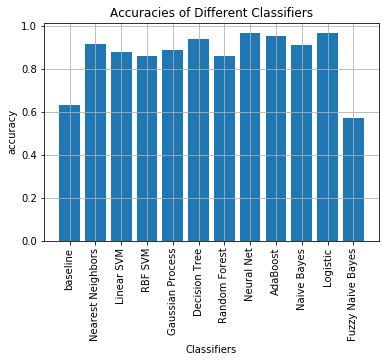

In [0]:
import matplotlib
import matplotlib.pyplot as plt

splits = [50, 100, 250, 500, 1000, 2500, 5000]
names = ['baseline', "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes",'Logistic', 'Fuzzy Naive Bayes']
keys = ["locality",	"industry",	"summary",	"specilities",	"interests",	"major",	"degree",	"affilition"]
results = [0.63,0.917,0.88,0.86,0.89,0.94,0.86, 0.965, 0.954, 0.91, 0.965, 0.57]
# for name, clf in zip(names, classifiers):
#   result = generate_results(clf, name, splits, keys)
#   results.append(result)
fig, ax = plt.subplots()
ax.bar(names, results)
plt.xticks(names, names, rotation='vertical')
plt_title = 'Accuracies of Different Classifiers'
ax.set(xlabel='Classifiers', ylabel='accuracy',
      title= plt_title)
ax.grid()
plt.show()

############
 For  Nearest Neighbors


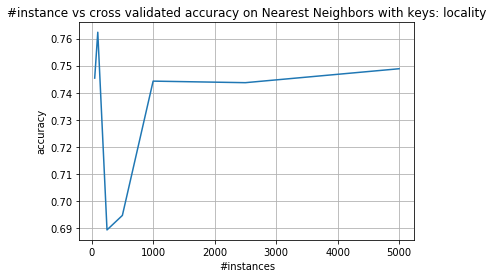

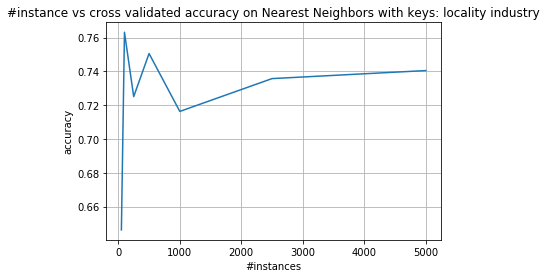

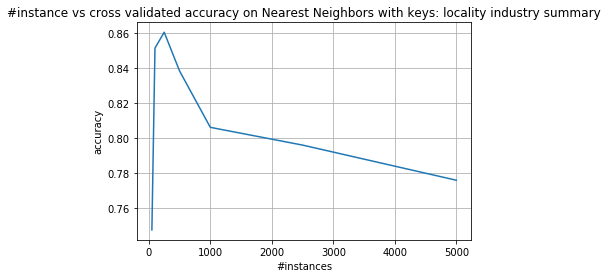

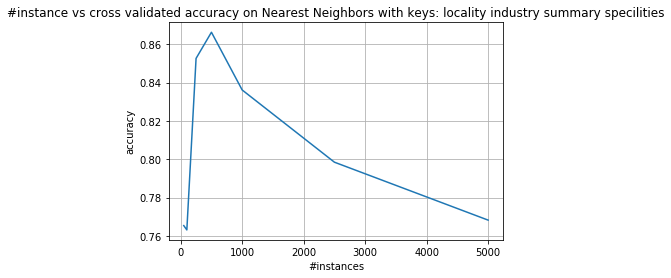

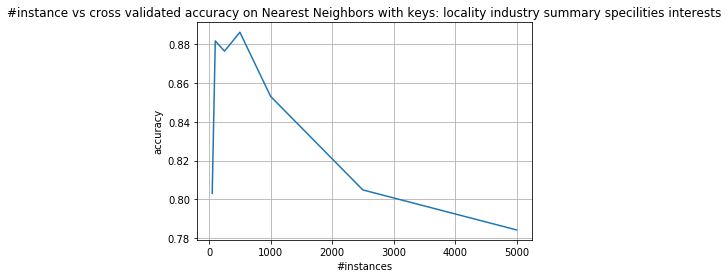

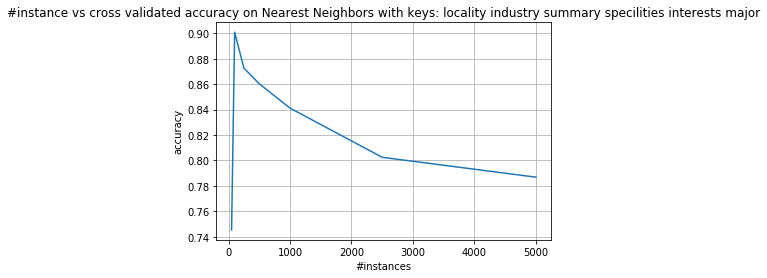

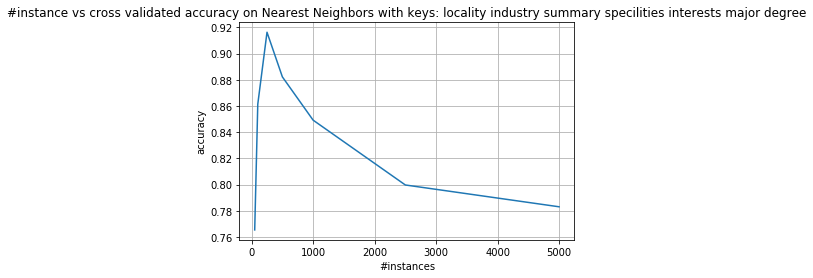

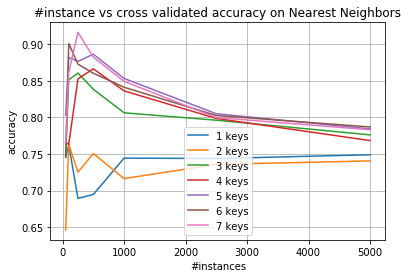

############
 For  Linear SVM


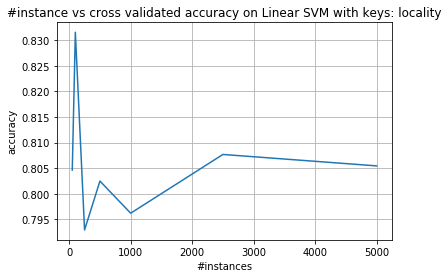

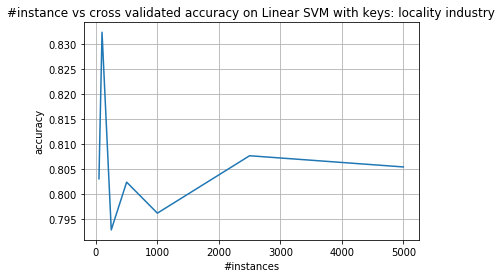

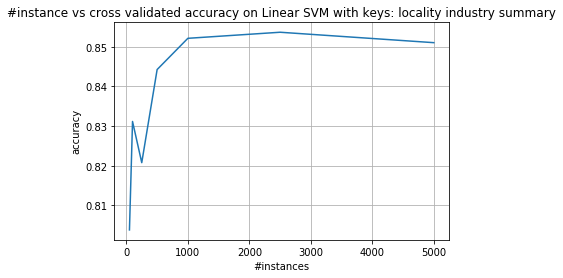

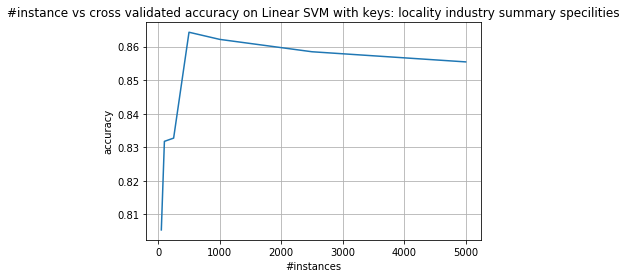

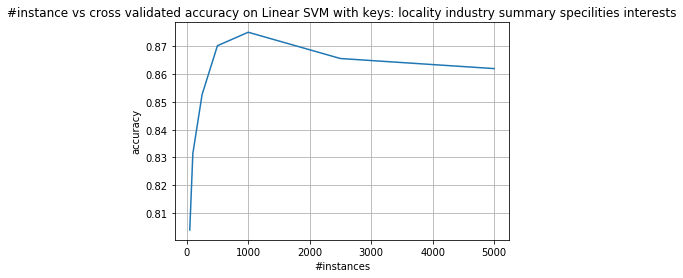

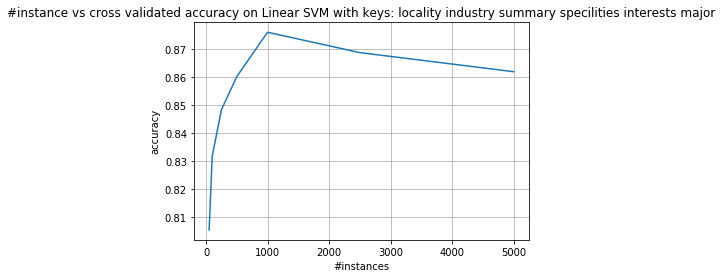

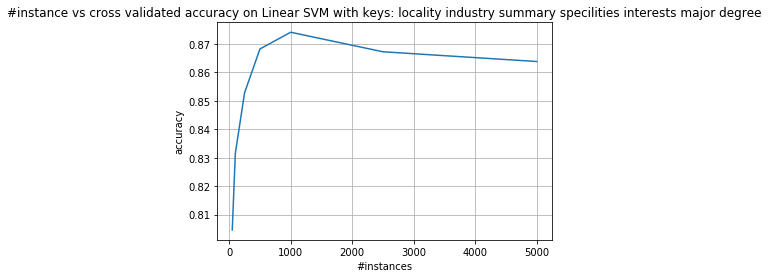

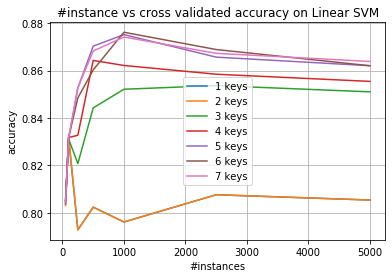

############
 For  RBF SVM


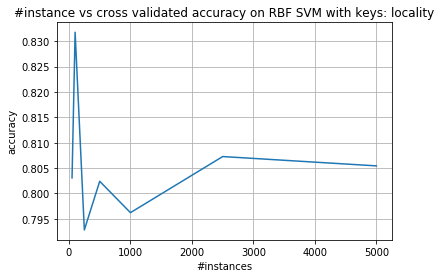

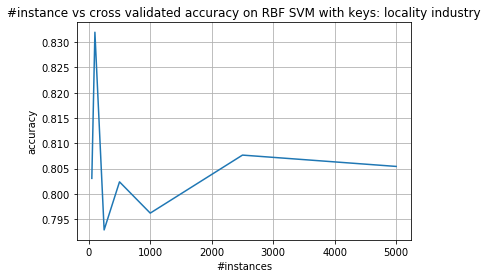

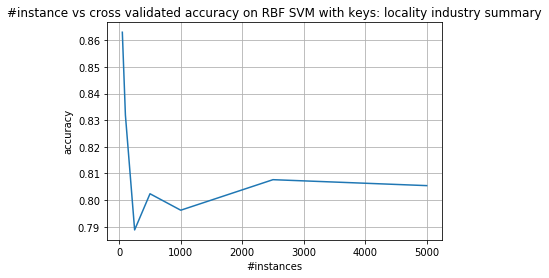

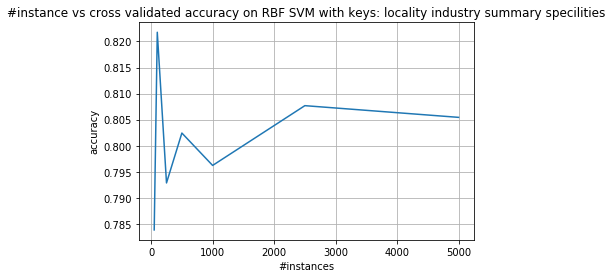

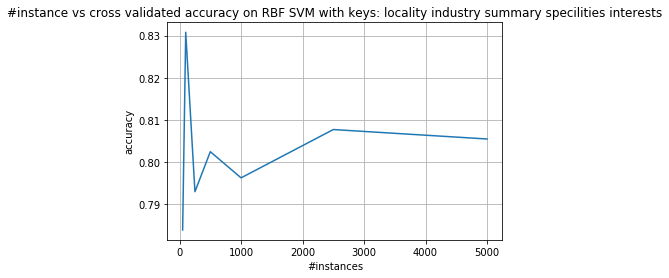

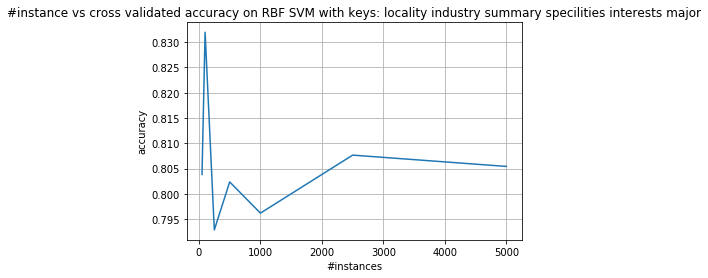

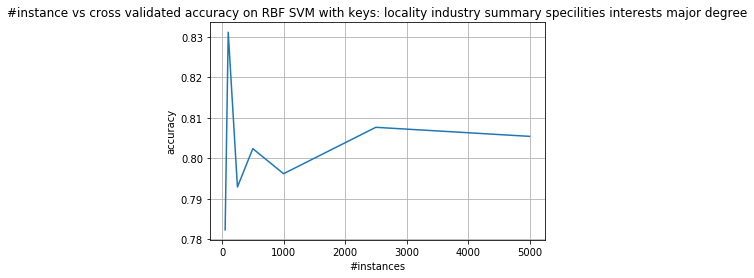

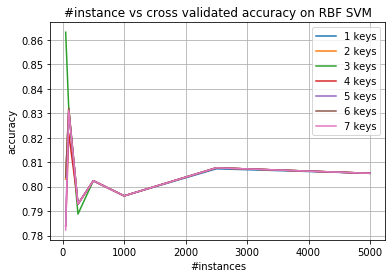

############
 For  Gaussian Process


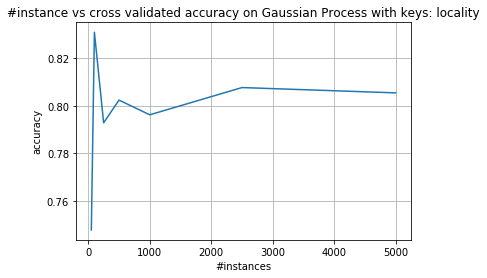

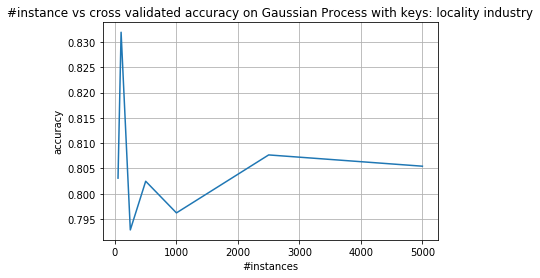

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.35421171e-05, -4.51595164e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


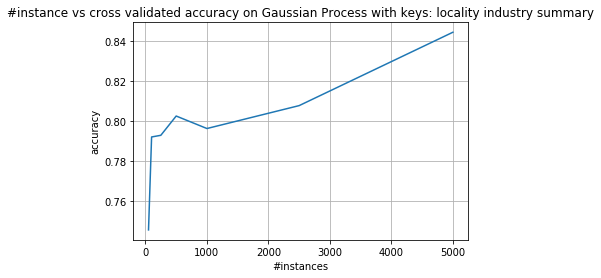

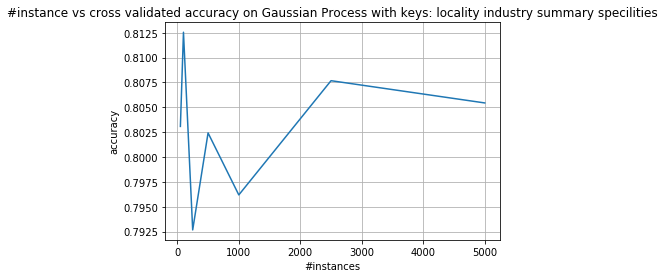

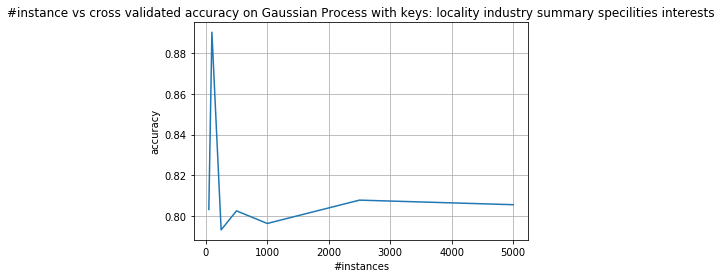

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.44457493e-06,  1.23820797e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 86, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


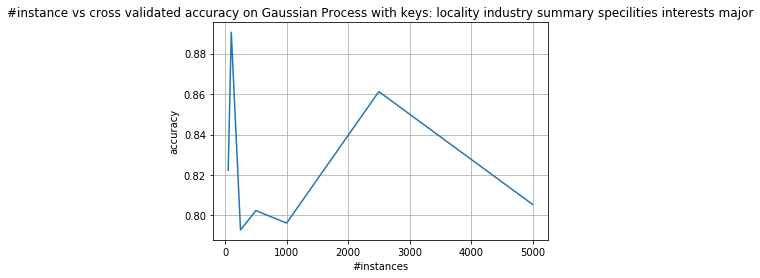

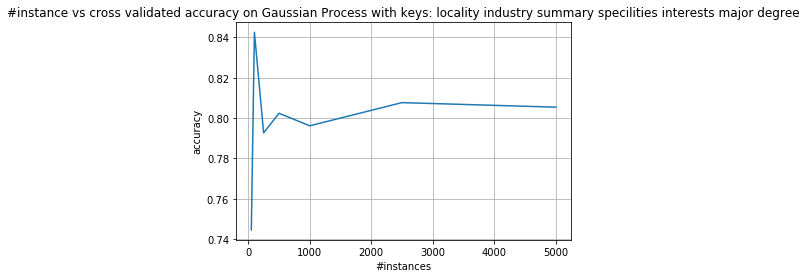

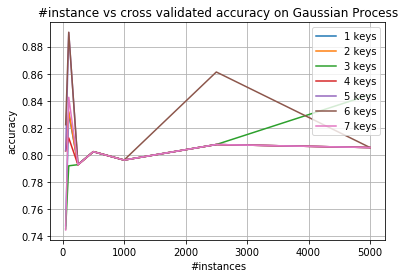

############
 For  Decision Tree


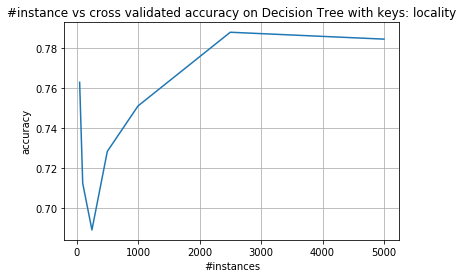

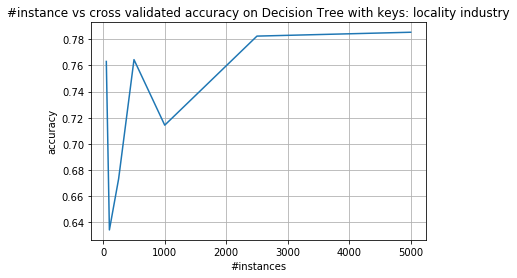

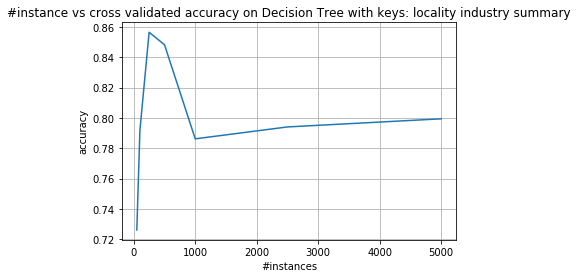

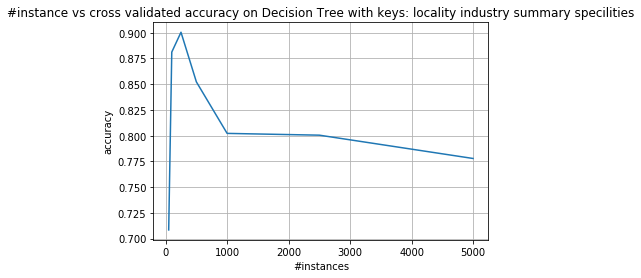

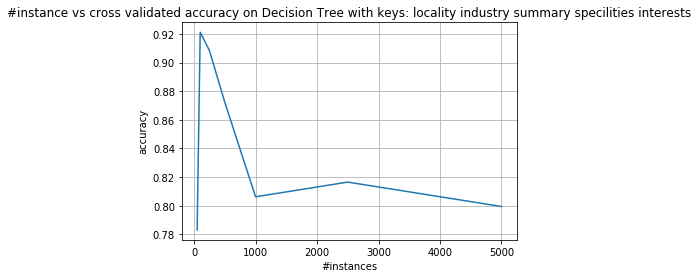

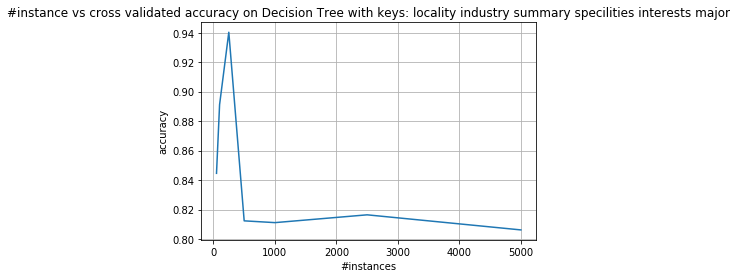

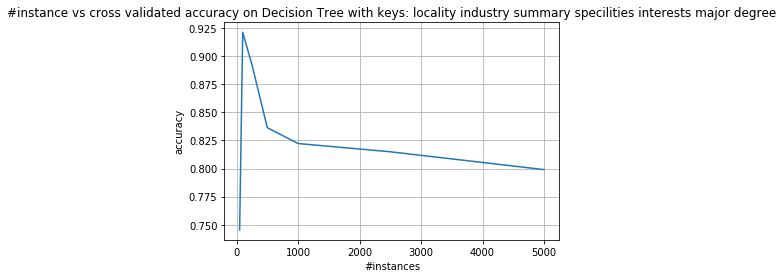

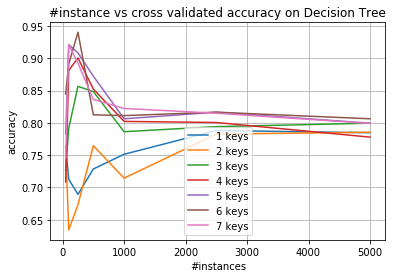

############
 For  Random Forest


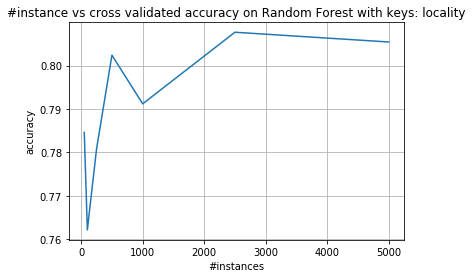

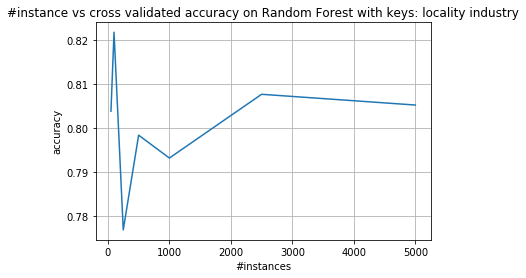

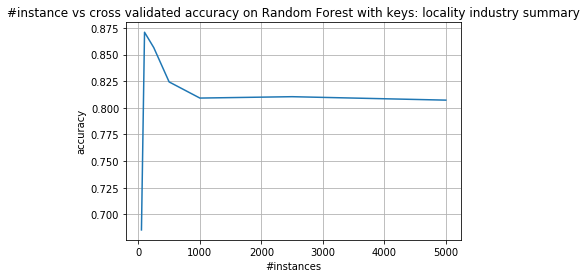

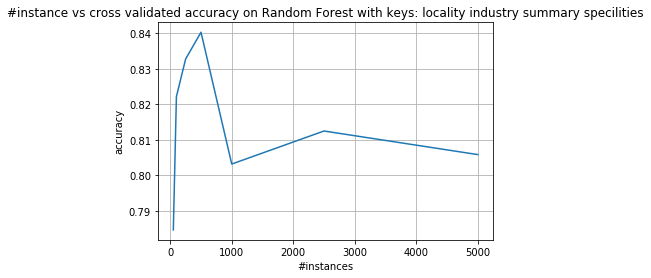

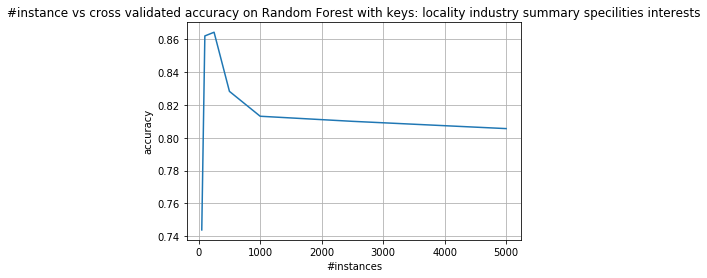

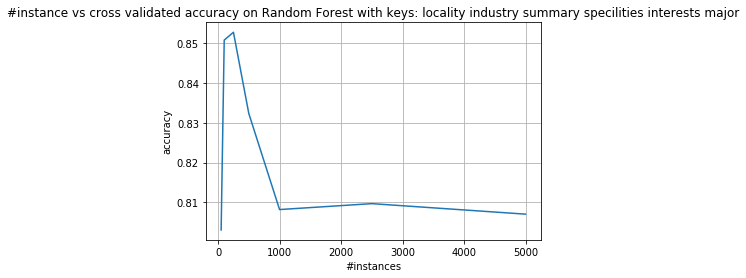

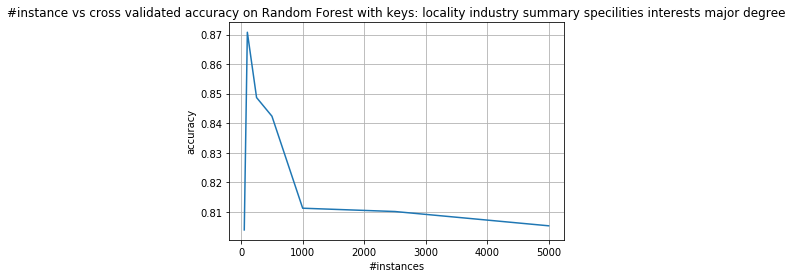

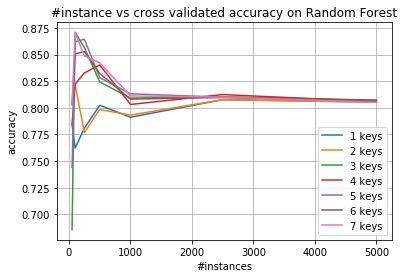

############
 For  Neural Net


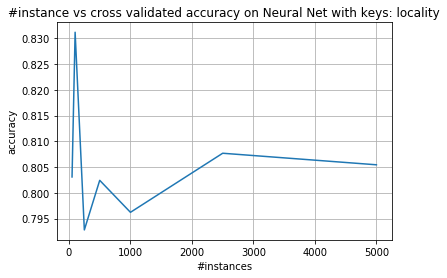

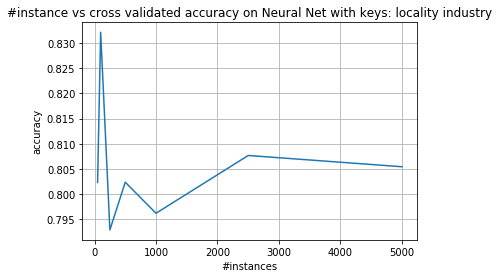

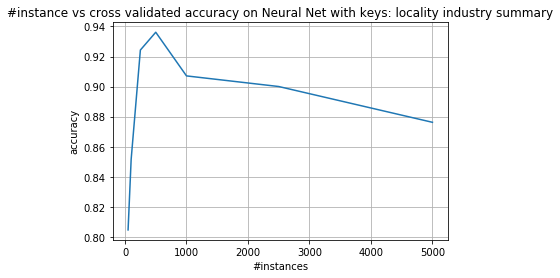

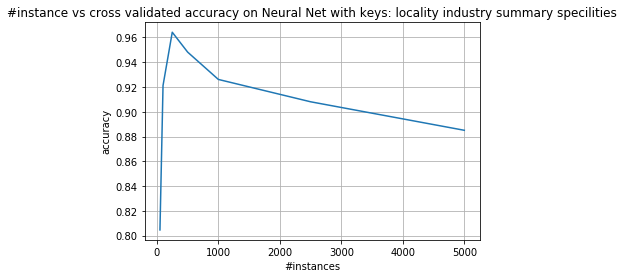

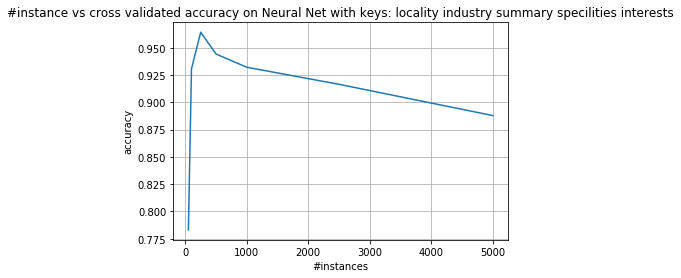

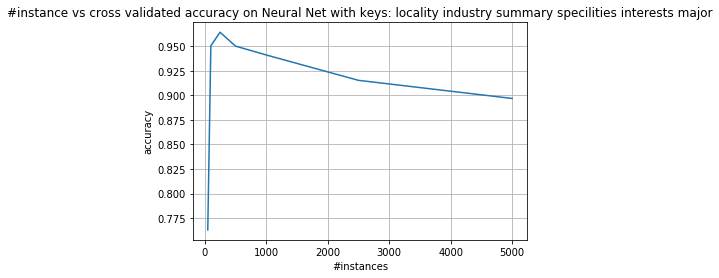

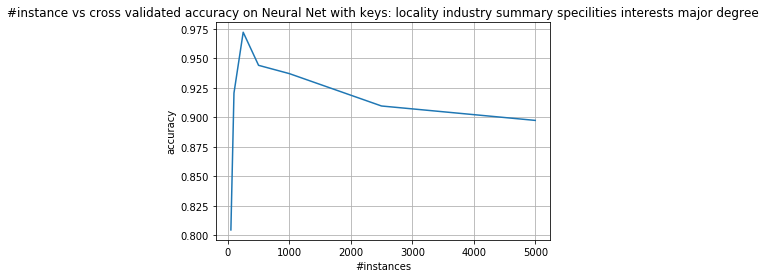

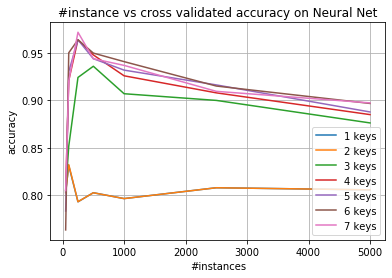

############
 For  AdaBoost


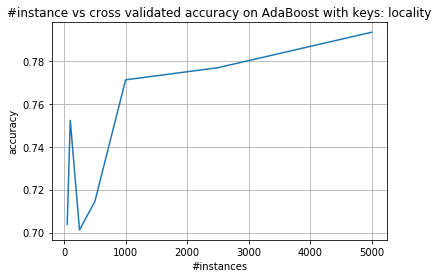

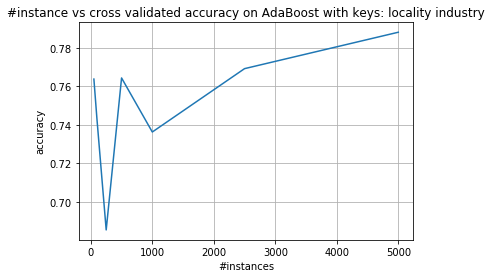

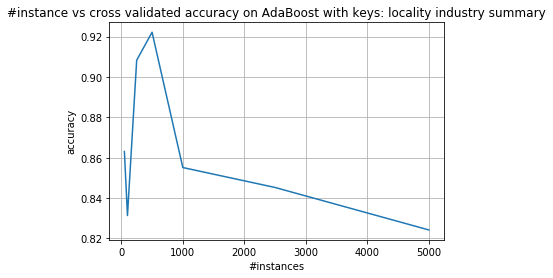

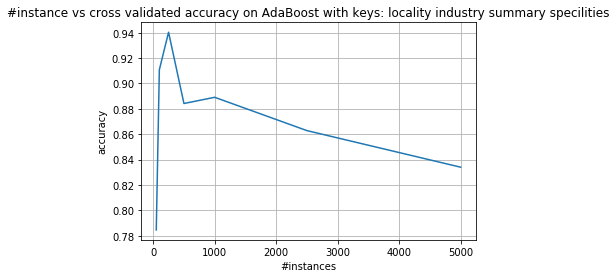

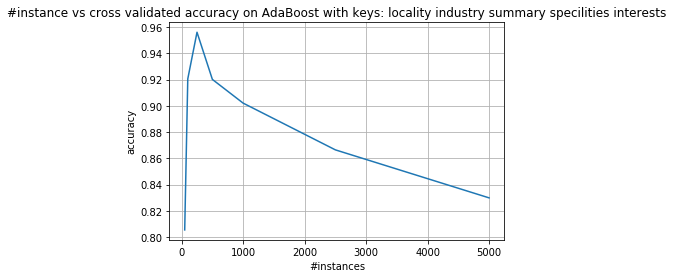

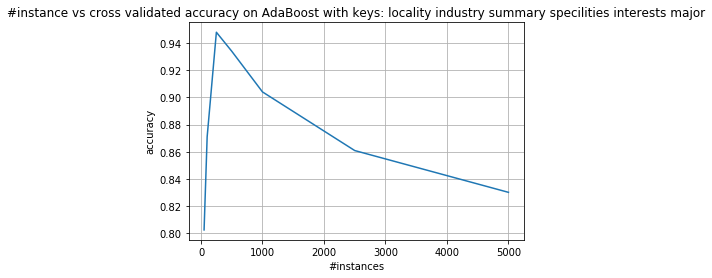

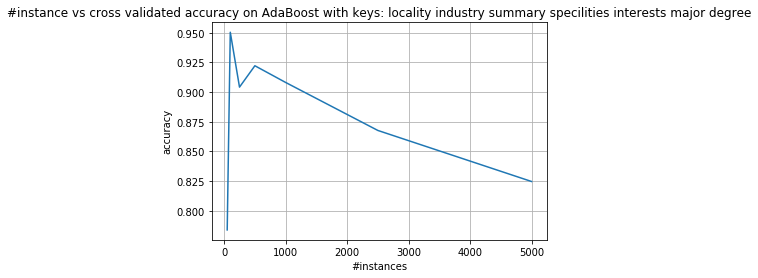

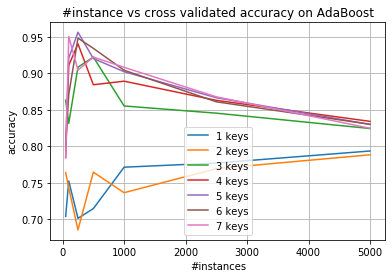

############
 For  Naive Bayes


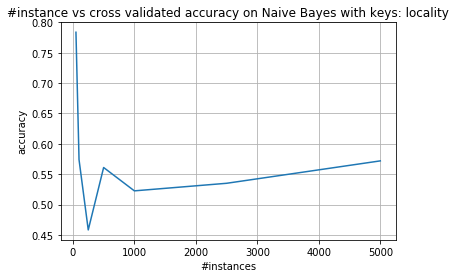

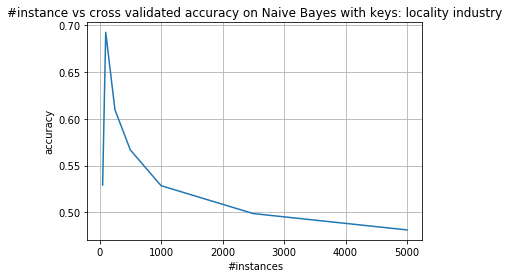

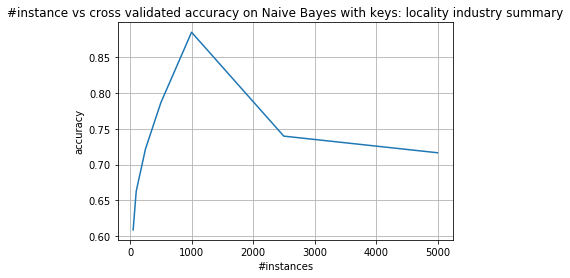

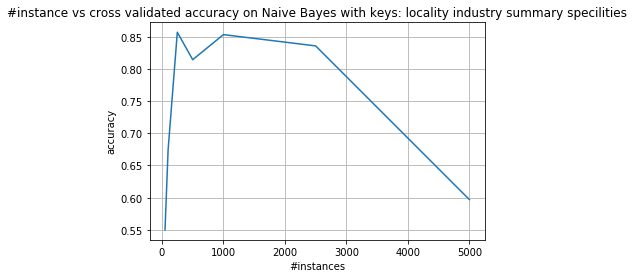

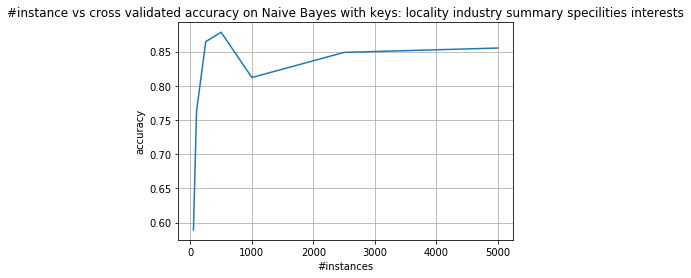

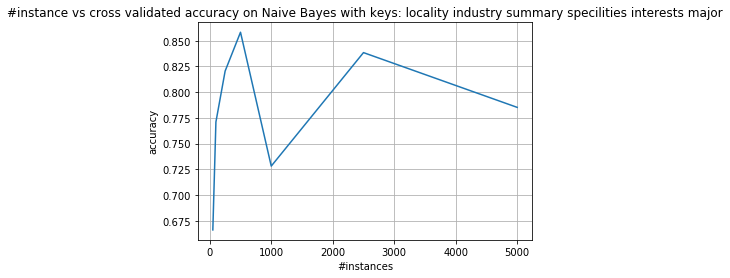

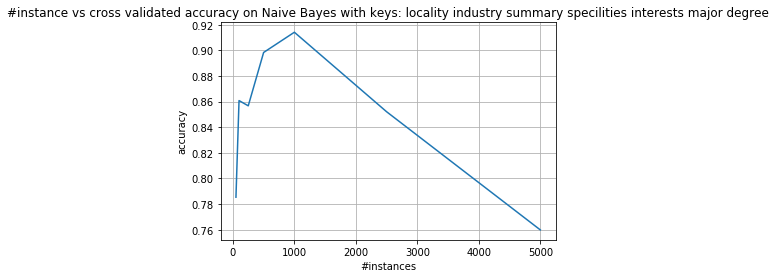

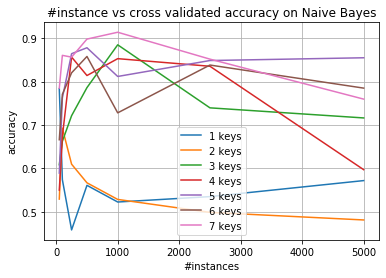

############
 For  Logistic


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

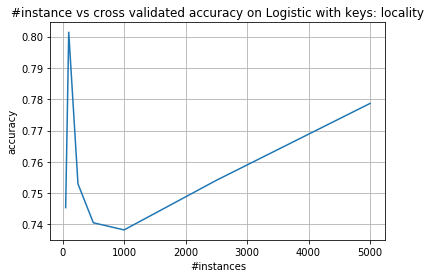

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

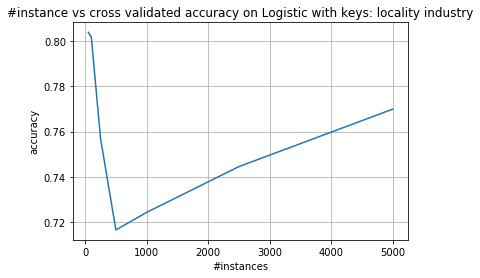

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

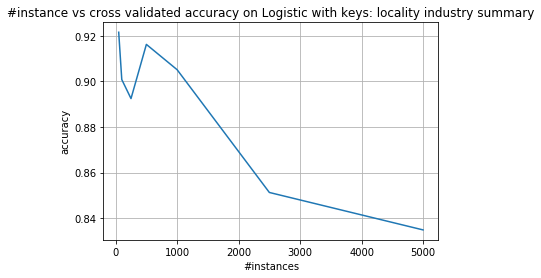

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

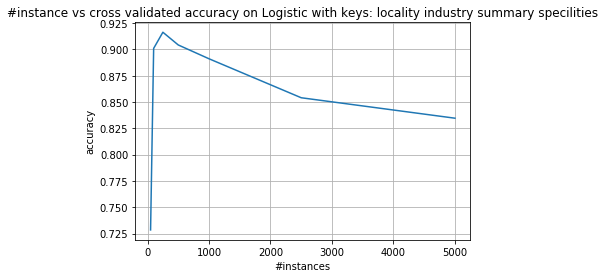

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

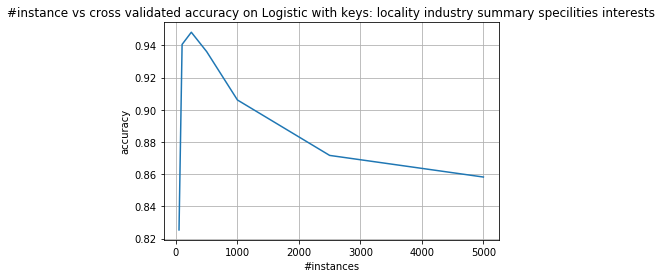

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

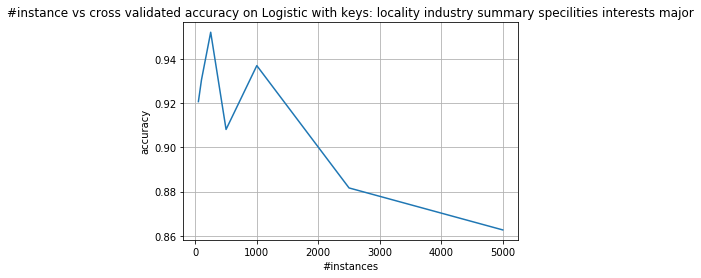

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

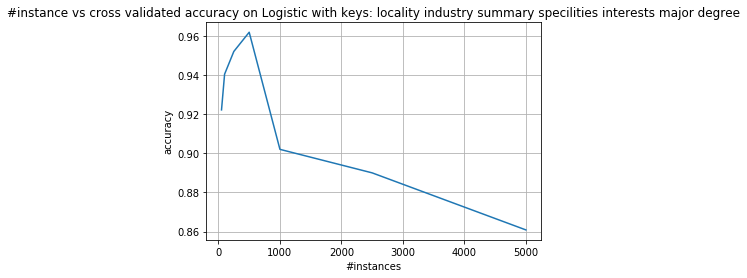

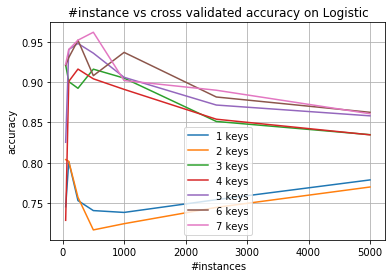

ValueError: ignored

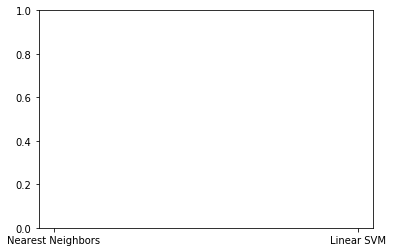

In [0]:
import matplotlib
import matplotlib.pyplot as plt

splits = [50, 100, 250, 500, 1000, 2500, 5000]
names = ['baseline', "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes",'Logistic' ]
keys = ["locality",	"industry",	"summary",	"specilities",	"interests",	"major",	"degree",	"affilition"]
results = [0.63,0.6,0.7,0.88,0.99,0.67,0.8, 0.78, 0.86, 0.85]
# for name, clf in zip(names, classifiers):
#   result = generate_results(clf, name, splits, keys)
#   results.append(result)
fig, ax = plt.subplots()
ax.bar(names, results)
plt.xticks(names, names, rotation='vertical')
plt_title = 'Accuracies of Different Classifiers'
ax.set(xlabel='Classifier', ylabel='accuracy',
      title= plt_title)
ax.grid()
plt.show()
    
  